In [2]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import pandas as pd

c:\Users\dvuAI\anaconda3\envs\env1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
import py_vncorenlp
import re
import os
# Đường dẫn tới thư mục chứa mô hình VnCoreNLP
save_dir = 'C:/Users/dvuAI/Downloads/VnCoreNLP-1.2/VnCoreNLP-1.2'

# Khởi tạo mô hình vnCoreNLP
model_split_text = py_vncorenlp.VnCoreNLP(save_dir=save_dir)

In [5]:


# 1. Tải dữ liệu từ CSV
data_path = "D:/NLP_CVS/pj_ML/data/comment_cleaned.csv"  # Đường dẫn đến tệp dữ liệu của bạn
data = pd.read_csv(data_path)


# Tiền xử lý văn bản 
import re

def preprocess_text(text):
    # Chuyển tất cả chữ cái thành chữ thường
    text = text.lower()
    # Loại bỏ các ký tự không phải chữ
    return text

# Áp dụng tiền xử lý cho cột 'comment'
data['cleaned_comment'] = data['comment'].apply(preprocess_text)

# Kiểm tra dữ liệu đã được tiền xử lý
print(data[['comment', 'cleaned_comment']].head())


                                             comment  \
0                    mùi vị tặng quà bé xíu mốc dùng   
1  đơn mình phát hiện hàng bị tráo thùng lốc lốc ...   
2                        khá nói rg lúc đưa tôi rg v   
3  lập xưởng ăn o biết nàonhin thấy phẩm màu quá ...   
4                           chất lượng đúng giá tiền   

                                     cleaned_comment  
0                    mùi vị tặng quà bé xíu mốc dùng  
1  đơn mình phát hiện hàng bị tráo thùng lốc lốc ...  
2                        khá nói rg lúc đưa tôi rg v  
3  lập xưởng ăn o biết nàonhin thấy phẩm màu quá ...  
4                           chất lượng đúng giá tiền  


In [6]:
# 2. Cập nhật Tokenizer cho VnCoreNLP

def vncorenlp_tokenizer(text):
    # Sử dụng annotate để phân tích văn bản và trả về các thông tin chi tiết
    annotated_text = model_split_text.annotate_text(text)
    
    # Lấy chỉ các từ từ kết quả trả về (field 'wordForm')
    tokens = [word_info['wordForm'] for word_info in annotated_text[0]]
    
    return tokens

print(vncorenlp_tokenizer("Tôi đã mua phải đồ dỏm chất lương rất tệ không có mùi vị gì"))

['Tôi', 'đã', 'mua', 'phải', 'đồ', 'dỏm', 'chất', 'lương', 'rất', 'tệ', 'không', 'có', 'mùi_vị', 'gì']


In [7]:
from torch.utils.data import DataLoader, Dataset
# 3. Dataset với VnCoreNLP Tokenizer
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]["comment"]
        label = self.data.iloc[idx]["label"]
        if label == "Negative":
            label = torch.tensor(0)
        if label == 'Normal' :
            label = torch.tensor(1)
        if label == 'Positive':
            label = torch.tensor(2)
        # Tokenize văn bản sử dụng VnCoreNLP
        tokens = self.tokenizer(text)
        length = torch.tensor(len(tokens))
        return {"label": label, "length": length, "tokens": tokens}

# Tokenizer cho tiếng Việt sử dụng VnCoreNLP
tokenizer = vncorenlp_tokenizer

# Chuyển dữ liệu CSV thành dataset
data = TextDataset(data, tokenizer)



In [8]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data, test_data = train_test_split(data, test_size=0.2,
                                         random_state=42,
                                         shuffle = True)

In [9]:
# Kiểm tra kích thước của các tập dữ liệu
print("Train size:", len(train_data))
print("Test size:", len(test_data))

Train size: 12986
Test size: 3247


In [10]:

labels = [example["label"] for example in train_data]  # Trích xuất các label từ train_data
output_dim = len(set(labels))  # Lấy số lượng label duy nhất
print(output_dim)
print(train_data[0])

12986
{'label': tensor(2), 'length': tensor(3), 'tokens': ['hành', 'tím', 'thơm']}


In [11]:
# 6. Chia dữ liệu thành tập huấn luyện và tập xác nhận
train_texts, valid_texts = train_test_split(train_data, test_size=0.25)

In [12]:
from torch.utils.data import DataLoader, TensorDataset
import torch
from collections import Counter

min_freq = 1
special_tokens = ["<unk>", "<pad>"]

# Sử dụng Counter để đếm các token trong train_data
counter = Counter()
for example in train_texts:
    counter.update(example["tokens"])
# print(counter.keys())
print(list(counter.keys()))

['nhìn', 'o', 'hàng', 'sấy', 'vụn', 'quá_trời', 'lấy', 'muỗng', 'ăn', 'nhỏ', 'cửa_hàng', 'chả', 'tí', 'uy_tín', 'biết', 'đủ', 'tôi', 'cần', 'kính', 'thích', 'thấy', 'ít', 'thêm', 'đời', 'thiếu', 'báo', 'muốn', 'trả', 'bênh', 'hoàn', 'tiền', 'làm', 'bán', 'trách_nhiệm', 'sữa', 'tắm', 'thơm', 'nó', 'nước', 'lỏng', 'nói', 'nấy', 'hài_lòng', 'l', 'nhỏ_xíu', 'cổ', 'em', 'bé', 'tuổi', 'nhân', 'dùng', 'thử', 'hơi', 'mỏng', 'đúng', 'số', 'người', 'nhiệt_tình', 'mẫuhàng', 'mình', 'nhận', 'maskmỏng', 'dáng', 'khẩu', 'khá', 'thất_vọng', 'đăng', 'kiểu', 'khác', 'số_lượng', 'tuýp', 'tặng', 'thực_phẩm', 'tốtai', 'mới', 'ngonnhân', 'viên', 'vẻ', 'nhiệt', 'chất_lượng', 'ổn', 'mọi', 'ngâm', 'thời', 'lâu', 'xíu', 'an', 'tuyệt_vời', 'bể', 'nhiều', 'hành', 'tím', 'khô', 'đóng_gói', 'tiện_lợi', 'túi', 'chứa', 'an_toàn', 'sức_khoẻ', 'ngọt', 'giấy', 'quá', 'kém', 'đặt', 'hộp', 'thịt', 'bì', 'đổi', 'ủa', 'hàng_hiệu', 'bình', 'bị', 'lỗi', 'n', 'tàu', 'thôi', 'chứ', 'trời_đất', 'trời', 'bền', 'trôi', 'kích_thướ

In [13]:
from torchtext.vocab import build_vocab_from_iterator

vocab = build_vocab_from_iterator(
    [[token] for token in counter.keys()],  # Bao bọc mỗi từ trong danh sách
    min_freq=min_freq,
    specials=special_tokens
)

unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]
vocab.set_default_index(unk_index)

# Kiểm tra vocab
print(vocab.get_stoi())

c:\Users\dvuAI\anaconda3\envs\env1\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\dvuAI\anaconda3\envs\env1\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


{'điện_biên': 5936, 'sàik': 4203, 'nguyênbtt': 3128, 'chân_đế': 452, 'ag': 7, 'nhà_nghỉ': 3332, 'miễm': 2701, 'nghỉ': 3079, 'bù': 175, 'biểu_tượng': 58, 'rù': 4061, 'thấ': 4564, 'chuyện': 411, 'đèn': 6022, 'kháng': 1964, 'thiện': 4382, '<unk>': 0, 'nước': 3607, 'síp': 4228, 'af': 6, 'bịp': 308, 'trắngý': 4929, 'cỡđặt': 947, 'thuận_an': 4412, 'hươngtệ': 1743, 'khám_xét': 1963, 'gram': 1369, 'bầu': 245, 'tuấn': 4986, 'lq': 2259, 'chuyến': 406, 'vậytuy': 5455, 'thịt': 4628, 'chồi': 602, 'rưa': 4071, '_': 2, 'liệuinox': 2203, 'lượngmỏng': 2487, 'dvjdnđ': 1015, 'tiềnkhông': 4735, 'cúa': 762, 'giói': 1297, 'thông_số': 4499, 'cáchdễ': 697, 'tuếp': 4989, 'hía': 1651, 'đăng_ký': 6083, 'đ': 5875, '<pad>': 1, 'đừa': 6318, 'da_dầu': 978, 'bg': 38, 'ăn_bớt': 5847, 'lên_đường': 2358, 'lượngkem': 2470, 'đầu_tư': 6162, 'êmot': 5804, 'bự': 370, 'đừg': 6319, 'êmdễ': 5803, 'riết': 4007, 'ba': 30, 'chửi': 638, 'chobđôir': 400, 'nóng': 3577, 'a': 3, 'giọt': 1346, 'bẹpxấu': 266, 'lầu': 2562, 'trưng': 4890, 

In [14]:
print(test_data[1])

{'label': tensor(0), 'length': tensor(20), 'tokens': ['chất_lượng', 'sản_phẩm', 'đồng_ý', 'nói', 'làm', 'vấn_đề', 'vận_chuyển', 'phải', 'đặt', 'đơn', 'mới', 'thôi', 'chả', 'rẻ', 'mấy', 'nghìn', 'chả', 'bõ', 'công', 'chờ']}


<font face = "Arial" size = "6"> Chuyển data từ list sang dict 
</font>

In [15]:

from datasets import Dataset
# Tạo Dataset từ dict cho train_data, valid_data và test_data
train_data_convert = Dataset.from_dict({
    'label':  [item['label'] for item in train_texts],
    'length': [item['length'] for item in train_texts],  # Giữ nguyên kiểu torch.tensor
    'tokens': [item['tokens'] for item in train_texts]
})

valid_data_convert = Dataset.from_dict({
    'label':  [item['label']for item in valid_texts],  
    'length': [item['length'] for item in valid_texts],  # Giữ nguyên kiểu torch.tensor
    'tokens': [item['tokens'] for item in valid_texts]
})

test_data_convert = Dataset.from_dict({
    'label':  [item['label'] for item in test_data],
    'length': [item['length'] for item in test_data],  # Giữ nguyên kiểu torch.tensor
    'tokens': [item['tokens'] for item in test_data]
})

In [16]:
print(train_data_convert[1])

{'label': 0, 'length': 6, 'tokens': ['cửa_hàng', 'chả', 'tí', 'uy_tín', 'biết', 'đủ']}


<font face = "Arial" size = "6"> Ta map Tokens có trong data thành các ids được định nghĩa trong vocab </font>

In [17]:
from datasets import Dataset
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [ ]:
train_data = train_data_convert.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data_convert.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data_convert.map(numericalize_example, fn_kwargs={"vocab": vocab})


In [ ]:
# sau khi map từ tokens sang ids
print(train_data[1])

<font face = "Arial" size = "6"> chuyển Label, Lenght, ids thành tensor </font>

In [19]:
train_data = train_data.with_format(type="torch", columns=["ids", "label", "length"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label", "length"])
test_data = test_data.with_format(type="torch", columns=["ids", "label", "length"])

In [20]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_length = [i["length"] for i in batch]
        batch_length = torch.stack(batch_length)
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return batch

    return collate_fn

In [21]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

batch_size = 512
train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [22]:
print(train_data[1])

{'label': tensor(0), 'length': tensor(6), 'ids': tensor([ 968,  523, 5061, 5336,   51, 6309])}


In [23]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        
        # Tạo một danh sách các lớp chập với các hàm kích hoạt
        self.convs = nn.ModuleList()
        for filter_size in filter_sizes:
            # Mỗi lớp chập sẽ có một lớp Conv1d và một hàm kích hoạt ReLU
            self.convs.append(
                nn.Sequential(
                    nn.Conv1d(embedding_dim, n_filters, filter_size),  # Lớp Conv1d
                    nn.ReLU()  # Hàm kích hoạt ReLU
                )
            )
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        embedded = embedded.permute(0, 2, 1)
        # embedded = [batch size, embedding dim, seq len]

        # Áp dụng các lớp chập và hàm kích hoạt ReLU
        conved = [conv(embedded) for conv in self.convs]
        # conved_n = [batch size, n filters, seq len - filter_sizes[n] + 1]
        
        # Áp dụng max pooling
        pooled = [conv.max(dim=-1).values for conv in conved]
        # pooled_n = [batch size, n filters]
        
        # Nối tất cả các đặc trưng lại với nhau
        cat = self.dropout(torch.cat(pooled, dim=-1))
        # cat = [batch size, n filters * len(filter_sizes)]
        
        # Dự đoán cuối cùng
        prediction = self.fc(cat)
        # prediction = [batch size, output dim]
        
        return prediction

In [24]:
vocab_size = len(vocab)
embedding_dim = 300
n_filters = 100
filter_sizes = [3, 5, 7]
output_dim = 3
dropout_rate = 0.25

model = CNN(
    vocab_size,
    embedding_dim,
    n_filters,
    filter_sizes,
    output_dim,
    dropout_rate,
    pad_index,
)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 2,392,503 trainable parameters


In [26]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

In [27]:
model.apply(initialize_weights)

CNN(
  (embedding): Embedding(6471, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(300, 100, kernel_size=(5,), stride=(1,))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv1d(300, 100, kernel_size=(7,), stride=(1,))
      (1): ReLU()
    )
  )
  (fc): Linear(in_features=300, out_features=3, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

<font face = "Arial" size = "6">
ở đây ta tả bộ trọng số đã train từ hugging face để làm trọng số khởi tạo cho model của mình nhằm tăng tốc độ train model lên
</font>

In [28]:
vectors = torchtext.vocab.GloVe()

In [29]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [30]:
model.embedding.weight.data = pretrained_embedding

In [31]:
lr = 5e-4

optimizer = optim.Adam(model.parameters(), lr=lr)

In [32]:
criterion = nn.CrossEntropyLoss()

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [34]:
model = model.to(device)
criterion = criterion.to(device)

In [35]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [36]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [37]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [38]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "D:/NLP_CVS/pj_ML/CNN/cnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


epoch: 0
train_loss: 1.128, train_acc: 0.465
valid_loss: 0.950, valid_acc: 0.570


evaluating...: 100%|██████████| 7/7 [00:01<00:00,  3.91it/s]


epoch: 1
train_loss: 0.955, train_acc: 0.580
valid_loss: 0.902, valid_acc: 0.603


evaluating...: 100%|██████████| 7/7 [00:01<00:00,  3.88it/s]


epoch: 2
train_loss: 0.902, train_acc: 0.603
valid_loss: 0.873, valid_acc: 0.631


evaluating...: 100%|██████████| 7/7 [00:01<00:00,  3.57it/s]


epoch: 3
train_loss: 0.837, train_acc: 0.644
valid_loss: 0.862, valid_acc: 0.631


evaluating...: 100%|██████████| 7/7 [00:01<00:00,  3.62it/s]


epoch: 4
train_loss: 0.823, train_acc: 0.649
valid_loss: 0.836, valid_acc: 0.643


evaluating...: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


epoch: 5
train_loss: 0.764, train_acc: 0.685
valid_loss: 0.822, valid_acc: 0.649


evaluating...: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


epoch: 6
train_loss: 0.751, train_acc: 0.684
valid_loss: 0.803, valid_acc: 0.654


evaluating...: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


epoch: 7
train_loss: 0.709, train_acc: 0.708
valid_loss: 0.790, valid_acc: 0.655


evaluating...: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


epoch: 8
train_loss: 0.677, train_acc: 0.727
valid_loss: 0.784, valid_acc: 0.658


evaluating...: 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]

epoch: 9
train_loss: 0.632, train_acc: 0.749
valid_loss: 0.759, valid_acc: 0.673


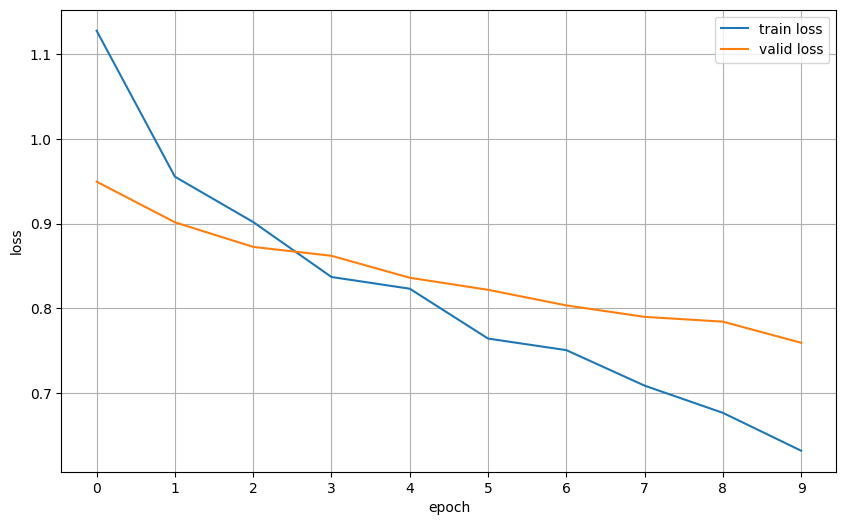

In [39]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

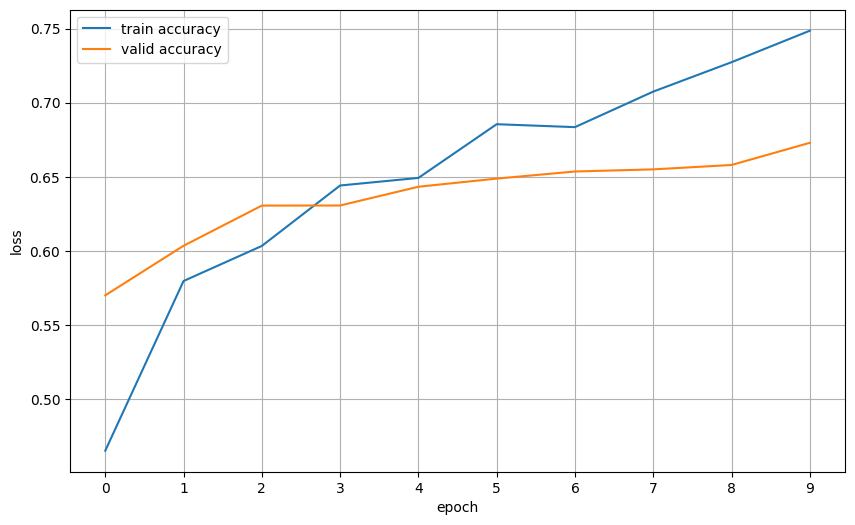

In [40]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [41]:
model.load_state_dict(torch.load("D:/NLP_CVS/pj_ML/CNN/cnn.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


In [42]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.749, test_acc: 0.674


In [48]:
Map_label = {
    0 : "Negative",
    1 : "Normal",
    2 : "Positive"
}
def predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    if len(ids) < min_length:
        ids += [pad_index] * (min_length - len(ids))
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    predict_label = Map_label[predicted_class]
    return predict_label, predicted_probability

In [49]:
text = "Đồ ăn ở đây rất tệ"
min_length = max(filter_sizes)

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

('Negative', 0.5972983241081238)

In [50]:
text = "đồ ăn ở đây ngon tuyệt"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

('Positive', 0.5065548419952393)

In [51]:
text = "mình thấy sản phẩm ở đây chỉ ở mức bình thường, không quá tốt"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

('Negative', 0.7902266383171082)

In [52]:
text = "sản phẩm chỉ ở mức tạm được, không quá tốt "

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

('Negative', 0.7152020931243896)